In [4]:
import jax
import jax.nn
import numpy as np
import numpyro
import optax
from numpyro.handlers import block, trace, seed
from jax import random, vmap
import matplotlib.pyplot as plt

In [178]:
%load_ext autoreload
%autoreload 2

from experiments.src.experiment import *
from experiments.src.data import *
from experiments.src.model import BNNRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
# %matplotlib inline
# import matplotlib
# matplotlib.use("nbAgg")  # noqa: E402

plt.rcParams.update({
    "axes.grid": True,  # show grid by default
    "axes.titlesize": 20,
    "axes.titlepad": 10.0,
    "figure.titlesize": 22,
    "figure.subplot.wspace": 0.3,
    "font.weight": "bold",  # bold fonts
    "xtick.labelsize": 15,  # large tick labels
    "ytick.labelsize": 15,  # large tick labels
    "lines.linewidth": 1,  # thick lines
    "lines.color": "k",  # black lines
    # "grid.color": "0.5",    # gray gridlines
    "grid.linestyle": "-",  # solid gridlines
    "grid.linewidth": 0.3,  # thin gridlines
    "savefig.dpi": 300,  # higher resolution output.
})

In [188]:
DEVICE = "gpu"
numpyro.set_platform(DEVICE)
# numpyro.set_host_device_count(NUM_CHAINS)
D_X = 2
BNN_SIZE = [32, 32, 16]
BETA = 0.1

In [189]:
data = ToyData1(D_X=D_X, train_size=100)

In [ ]:
# data = DataSlice(ToyData1(D_X=D_X, train_size=100), slice(0, 50))

In [66]:
# data = DataSlice(LinearData(intercept=1, beta=1, D_X=D_X, train_size=100), slice(0, 50))

In [190]:
bnn = BNNRegressor(
    nonlin=jax.nn.relu,
    D_X=D_X,
    D_Y=1,
    D_H=BNN_SIZE,
    biases=True,
    obs_model='loc_scale',
    prior_scale=np.sqrt(2),
    prior_type='xavier',
)
bnn.get_weight_dim()

162

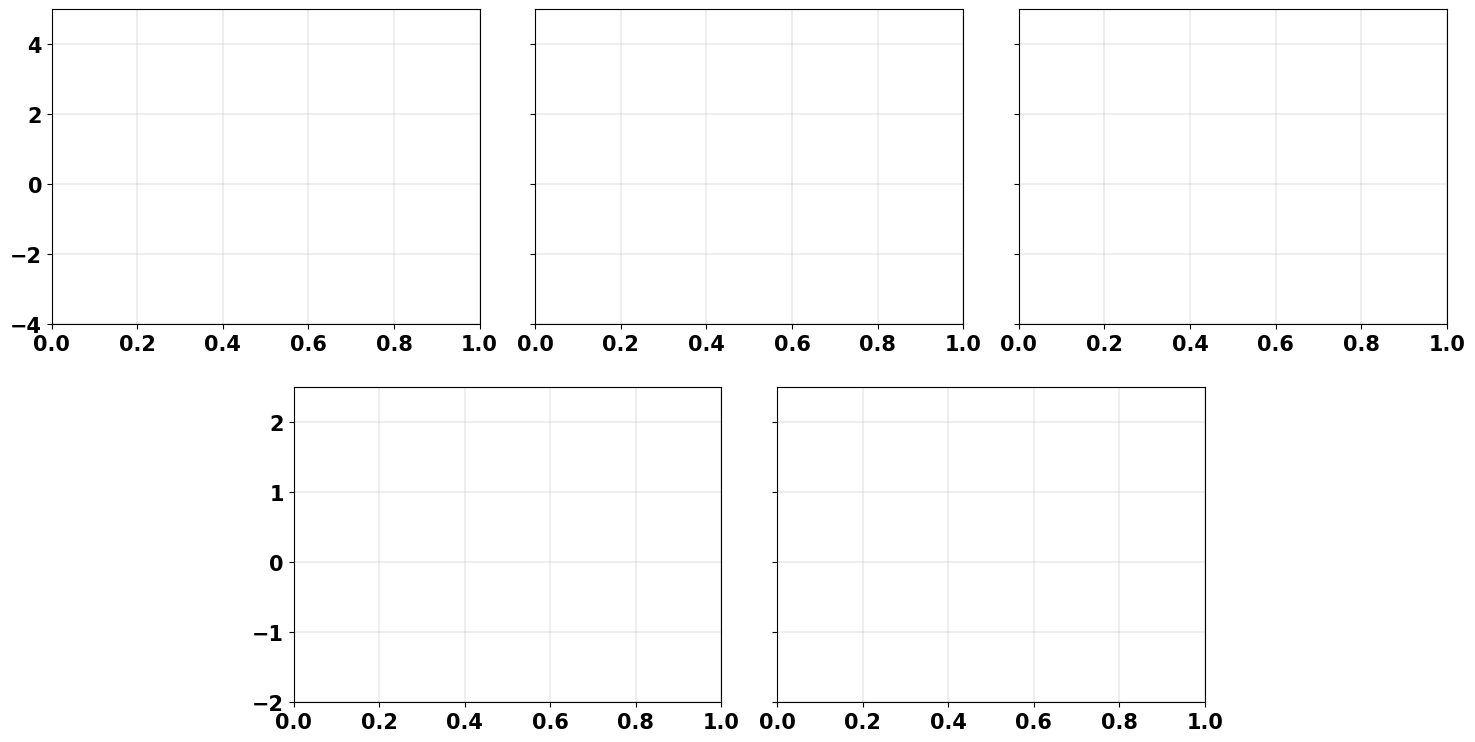

In [145]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(2, 6)

axs = []

for i in range(0, 5):
    if i < 3:
        if i == 0:
            ax = plt.subplot(gs[0, 2 * i:2 * i + 2])
        else:
            ax = plt.subplot(gs[0, 2 * i:2 * i + 2], sharey=axs[0])
            ax.sharey(axs[0])
            plt.setp(ax.get_yticklabels(), visible=False)
        ax.set_ylim(-4, 5)
    else:
        if i == 3:
            ax = plt.subplot(gs[1, 2 * i - 5:2 * i + 2 - 5])
        else:
            ax = plt.subplot(gs[1, 2 * i - 5:2 * i + 2 - 5])
            ax.sharey(axs[3])
            plt.setp(ax.get_yticklabels(), visible=False)
        ax.set_ylim(-4, 5)
    axs.append(ax)

ax_prior, ax_hmc, ax_vi, ax_laplace, ax_swag = axs

In [191]:
plot_prior_samples(bnn, data, fig=fig, ax=ax_prior)
ax_prior.set_title("Prior")
# fig.savefig("figs/prior.png")

Text(0.5, 1.0, 'Prior')

Initial eval loss: 255.0519 (lik: -157.6705, kl: 97.3814)


100%|██████████| 50/50 [00:08<00:00,  5.79it/s, init loss: 255.0519, avg. train loss / eval. loss [49000-50000]: 88.2689 / 88.2696]



SVI elapsed time: 9.777890920639038


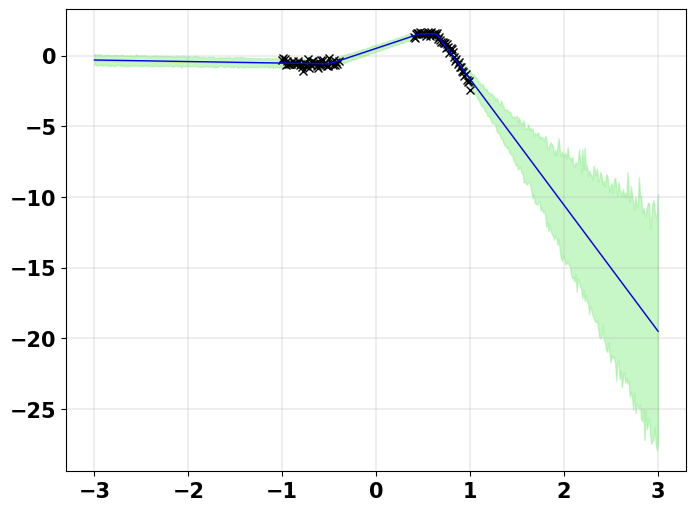

In [192]:
map = AutoDeltaVIExperiment(bnn, data, max_iter=50_000, lr_schedule=optax.constant_schedule(-0.001))
_ = map.run(random.PRNGKey(0))

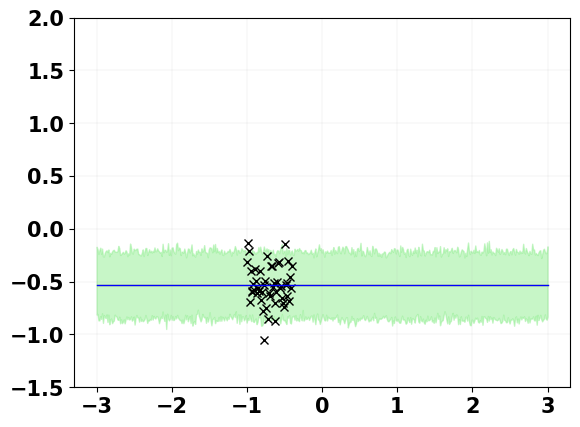

In [42]:
# fig, ax = plt.subplots()
# map.make_plots(fig=fig, ax=ax)
# ax.set_ylim(-1.5, 2)
# None

In [193]:
hmc = BasicHMCExperiment(bnn, data, num_warmup=100, num_samples=400, init_params={'w': map._params['w_loc']})

sample: 100%|██████████| 500/500 [00:47<00:00, 10.52it/s, 511 steps of size 6.21e-03. acc. prob=0.78] 



MCMC elapsed time: 51.08483004570007


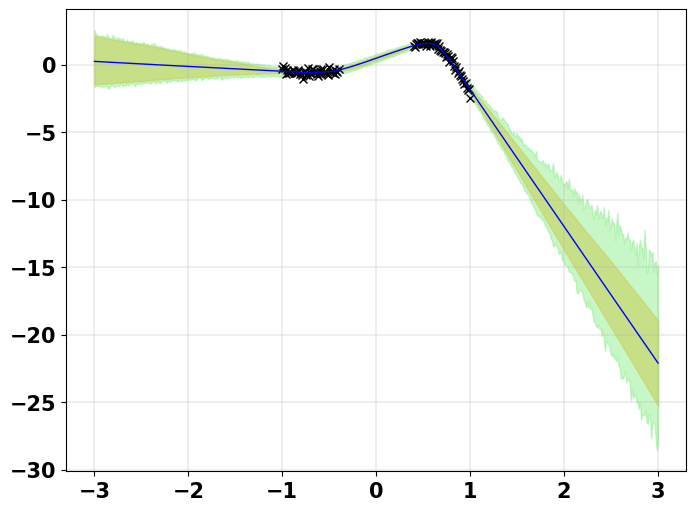

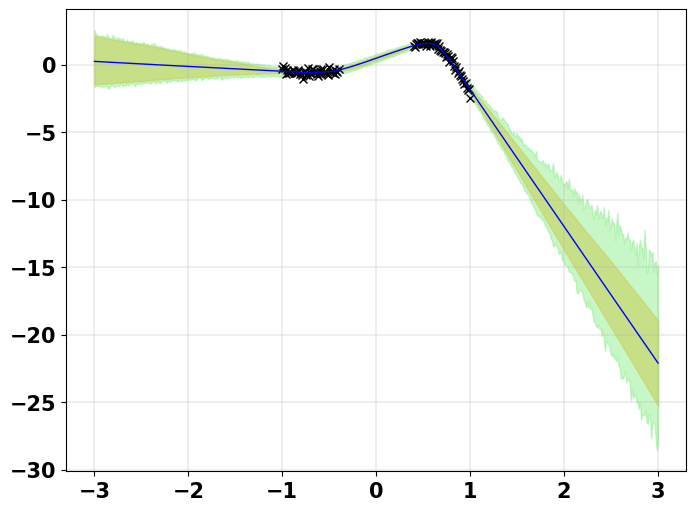

In [194]:
hmc.run(random.PRNGKey(0))

In [15]:
# hmc.make_predictions(random.PRNGKey(1))

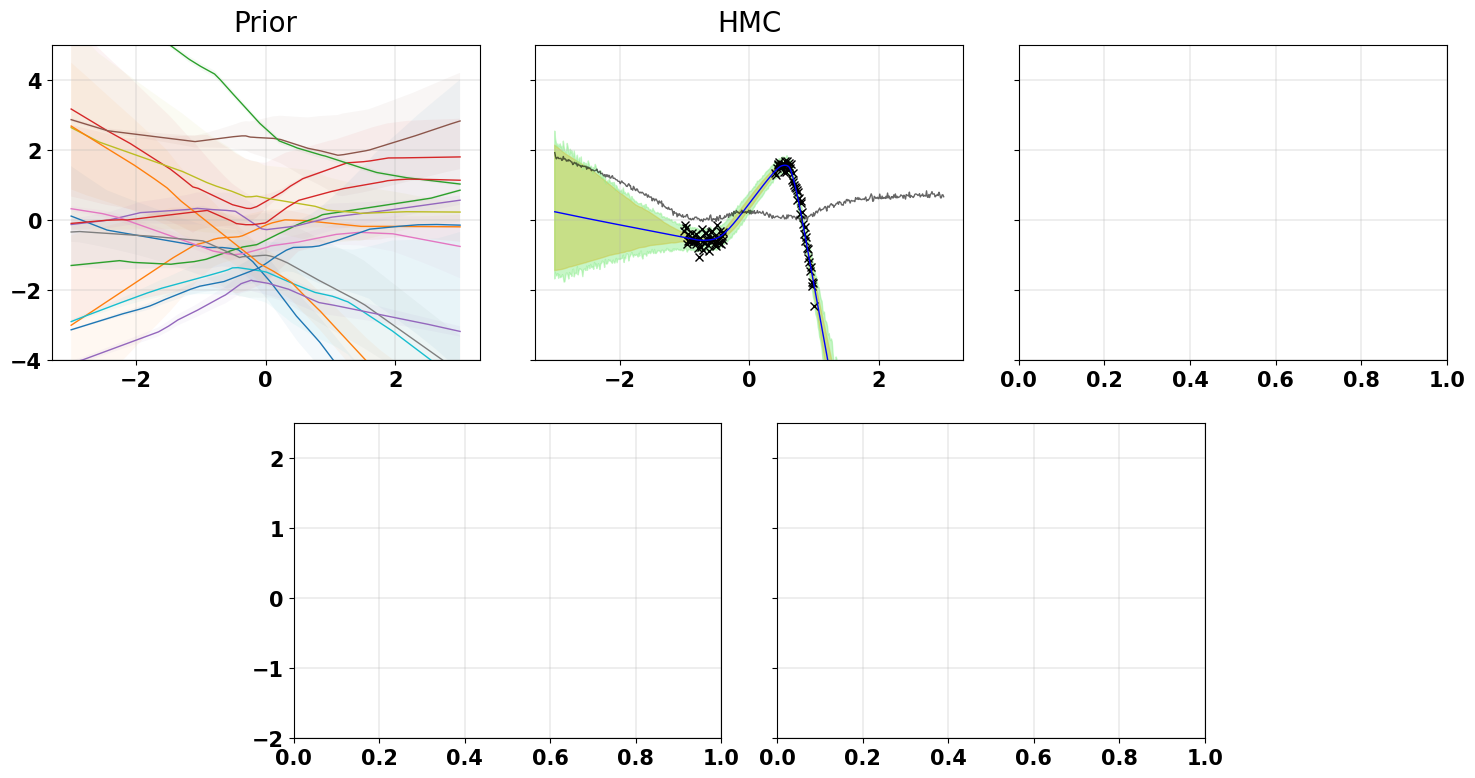

In [195]:
ax_hmc.set_title("HMC")
t = data.test[0][:, 1]

# for i in range(15):
#     mu =  hmc._predictions['Y_mean'][i, :, 0]
#     sigma = hmc._predictions['Y_scale'][i, :, 0]
#     ax_hmc.plot(t, mu)
#     ax_hmc.fill_between(t, mu - sigma, mu  + sigma, alpha=0.05)
# ax_hmc.plot(data.train[0][:, 1], data.train[1][:, 0], "kx")
hmc.make_plots(fig=fig, ax=ax_hmc, plot_bald=True)

# fig.savefig("figs/hmc.png")

In [196]:
bnn.BETA = BETA

In [197]:
vi = BasicMeanFieldGaussianVIExperiment(bnn, data, num_samples=400, max_iter=150_000, lr_schedule=optax.constant_schedule(-0.0005), num_particles=1, num_eval_particles=16)

Initial eval loss: 330.9317 (lik: -157.6710, kl: 173.2607)


100%|██████████| 50/50 [00:36<00:00,  1.36it/s, init loss: 330.9258, avg. train loss / eval. loss [147000-150000]: -18.4477 / -18.9796]



SVI elapsed time: 39.44018888473511


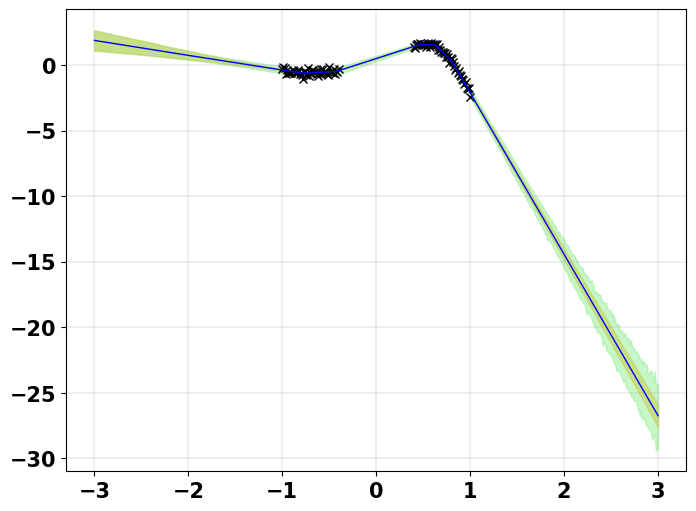

In [198]:
_ = vi.run(random.PRNGKey(0))

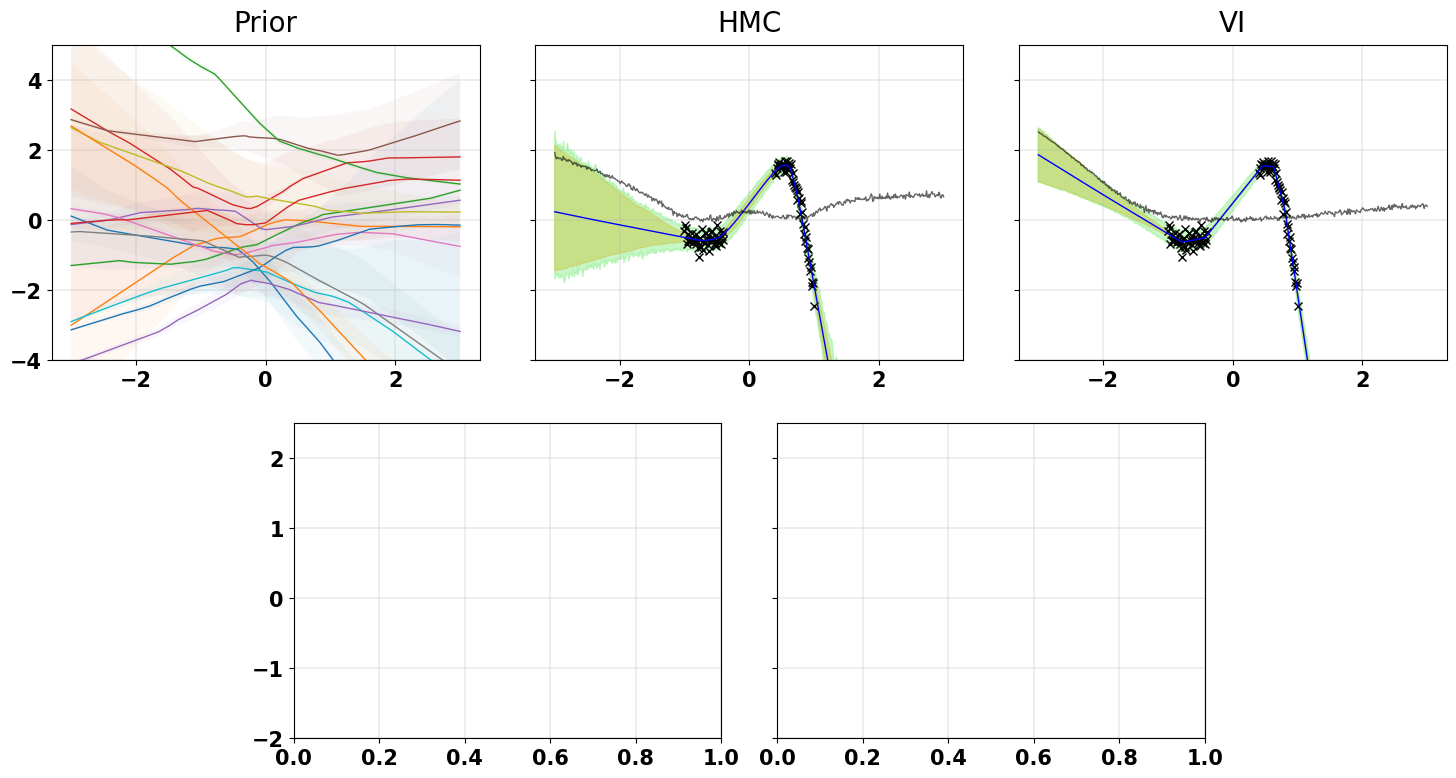

In [199]:
ax_vi.set_title("VI")

# for i in range(15):
#     mu = vi._predictions['Y_mean'][i, :, 0]
#     sigma = vi._predictions['Y_scale'][i, :, 0]
#     ax_vi.plot(t, mu)
#     ax_vi.fill_between(t, mu - sigma, mu + sigma, alpha=0.05)
# ax_vi.plot(data.train[0][:, 1], data.train[1][:, 0], "kx")
vi.make_plots(fig=fig, ax=ax_vi, plot_bald=True)

# fig.savefig("figs/vi.png")

In [200]:
bnn.BETA = 1.0

In [201]:
laplace = AutoDiagonalLaplaceExperiment(bnn, data, trained_map_experiment=map, shrink=2000)

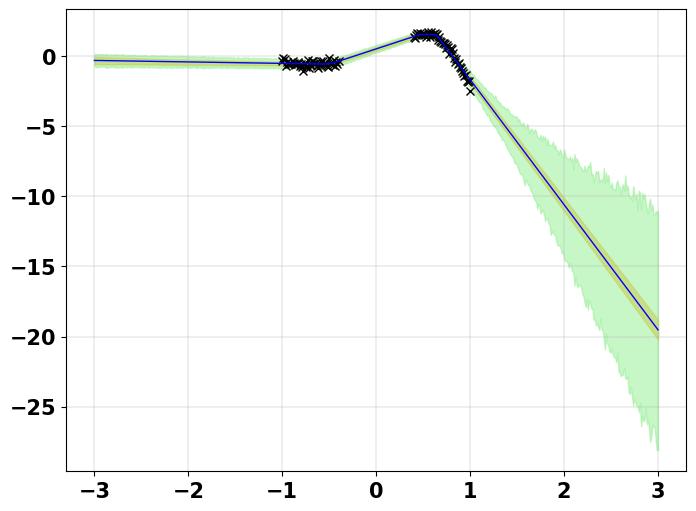

In [202]:
_ = laplace.run(random.PRNGKey(0))

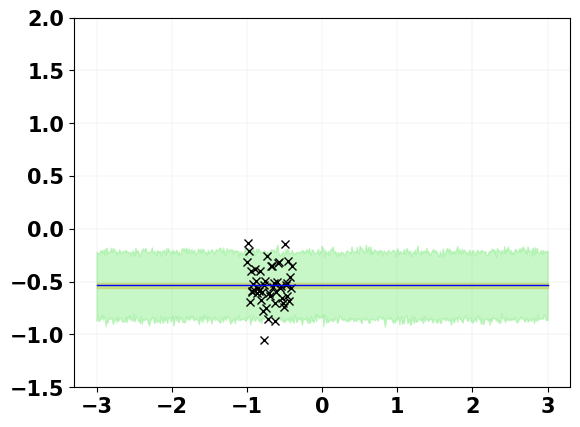

In [43]:
# fig, ax = plt.subplots()
# laplace.make_plots(fig=fig, ax=ax)
# ax.set_ylim(-1.5, 2)
# None

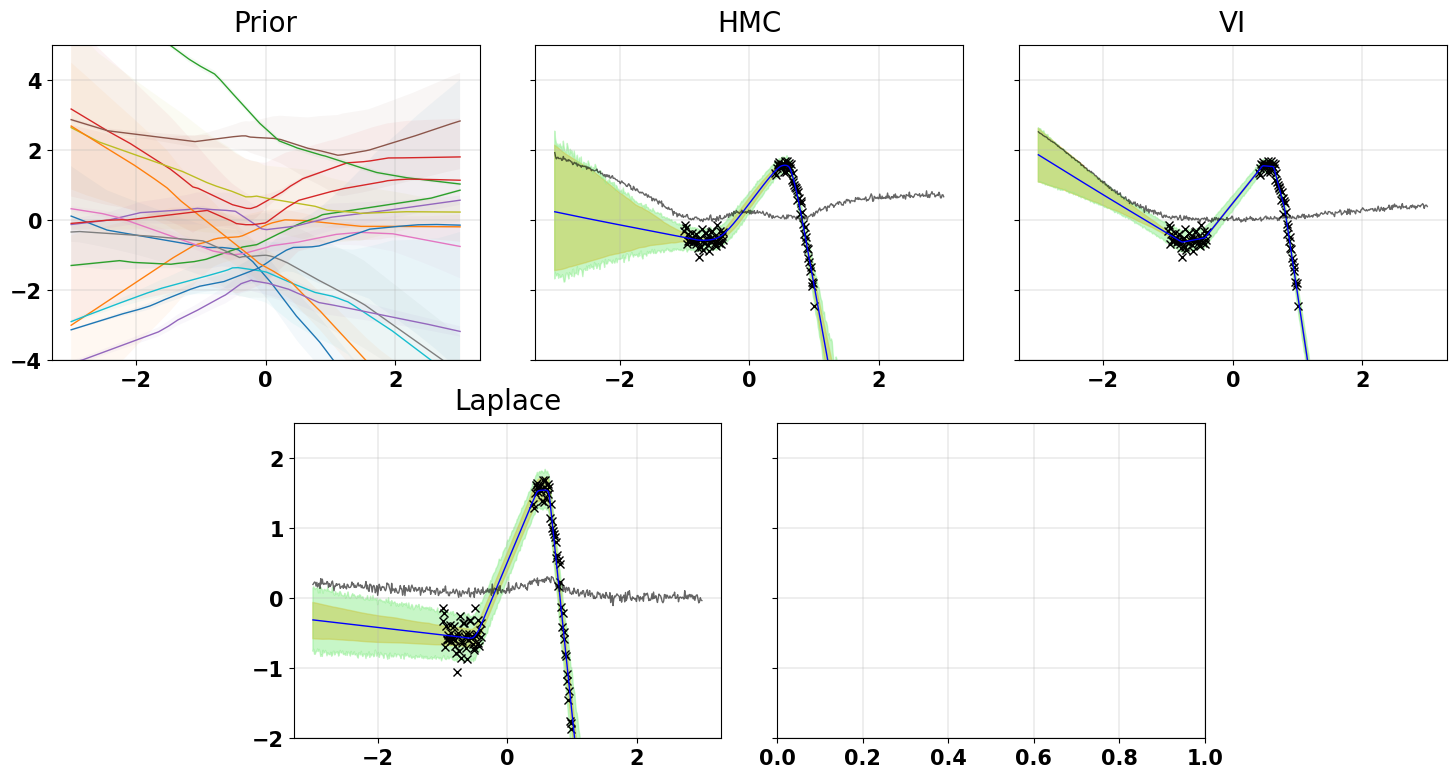

In [203]:
ax_laplace.set_title("Laplace")

# for i in range(15):
#     mu = laplace._predictions['Y_mean'][i, :, 0]
#     sigma = laplace._predictions['Y_scale'][i, :, 0]
#     ax_laplace.plot(t, mu)
#     ax_laplace.fill_between(t, mu - sigma, mu + sigma, alpha=0.05)
# ax_laplace.plot(data.train[0][:, 1], data.train[1][:, 0], "kx")
laplace.make_plots(fig=fig, ax=ax_laplace, plot_bald=True)

# fig.savefig("figs/laplace.png")

In [204]:
swag = SWAGExperiment(bnn, data, map, rank=20, learning_rate=0.005, num_samples=400)

100%|██████████| 5000/5000 [00:08<00:00, 575.00it/s, init loss: 88.2696, avg. loss [4751-5000]: 101.0307]


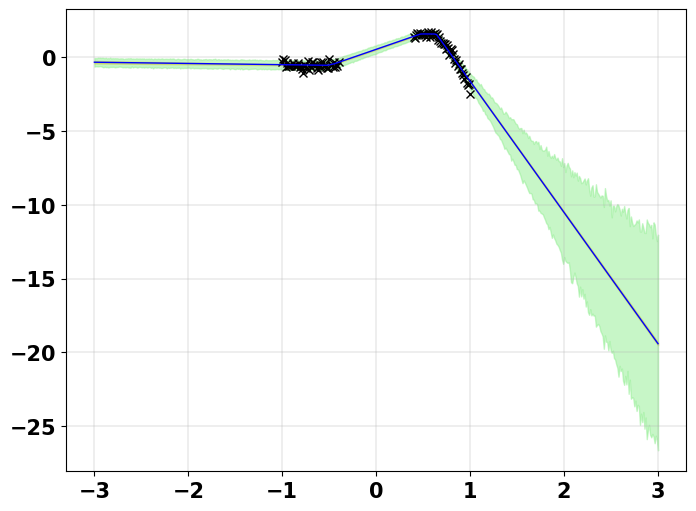

In [205]:
_ = swag.run(random.PRNGKey(0))

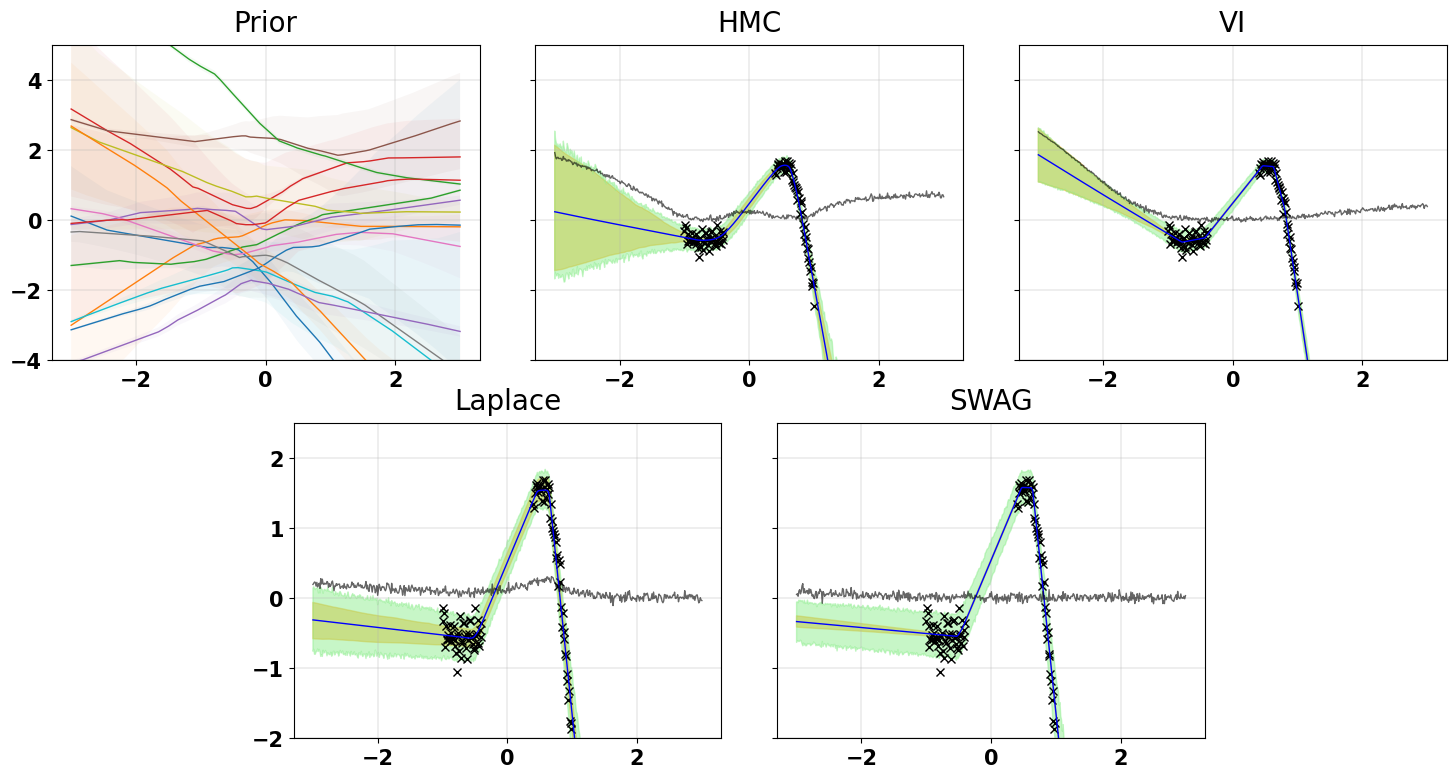

In [206]:
ax_swag.set_title("SWAG")

# for i in range(15):
#     mu = swag._predictions['Y_mean'][i, :, 0]
#     sigma = swag._predictions['Y_scale'][i, :, 0]
#     ax_swag.plot(t, mu)
#     ax_swag.fill_between(t, mu - sigma, mu + sigma, alpha=0.05)
# ax_swag.plot(data.train[0][:, 1], data.train[1][:, 0], "kx")
swag.make_plots(fig=fig, ax=ax_swag, plot_bald=True)

# fig.savefig("figs/swag.png")

In [212]:
fig.tight_layout()
fig.savefig("figs/complexity_comparison_bald.pdf")